# Level 1: Baseline Model - CIFAR-10 Classification

## Objective
Build a baseline classifier using ResNet50 transfer learning
- Expected Accuracy: 85-95%
- Pass if accuracy ≥85% and code is clean


In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## Data Loading with Proper Split (80-10-10)


In [ ]:
# Define transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# CIFAR-10 has 50,000 training images and 10,000 test images
# We need to split training into 80% train (40,000) and 10% validation (10,000)
# Test set remains 10,000 (10%)

train_size = 40000
val_size = 10000

# Create indices for train/val split
indices = torch.randperm(len(train_dataset)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]

# Create subset datasets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f'Train samples: {len(train_subset)}')
print(f'Validation samples: {len(val_subset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Total: {len(train_subset) + len(val_subset) + len(test_dataset)}')


100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]


Train samples: 40000
Validation samples: 10000
Test samples: 10000
Total: 60000


## Model Setup - ResNet50 Transfer Learning


In [ ]:
# Load pretrained ResNet50
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the final layer for CIFAR-10 (10 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Move model to device
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


Model parameters: 23,528,522


## Training Function


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(loader, desc='Training'):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


## Validation Function


In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc='Validating'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


## Training Loop


In [ ]:
# Training parameters
num_epochs = 50

# History tracking
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Save history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs('models', exist_ok=True)
        torch.save(model.state_dict(), 'models/level1_baseline.pth')
        print(f'New best validation accuracy: {best_val_acc:.2f}% - Model saved!')

print(f'\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%')



Epoch 1/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 26.08it/s]


Train Loss: 0.9983, Train Acc: 65.27%
Val Loss: 0.5544, Val Acc: 80.98%
New best validation accuracy: 80.98% - Model saved!

Epoch 2/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 26.74it/s]


Train Loss: 0.4404, Train Acc: 84.85%
Val Loss: 0.5127, Val Acc: 82.64%
New best validation accuracy: 82.64% - Model saved!

Epoch 3/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 29.05it/s]


Train Loss: 0.2621, Train Acc: 91.12%
Val Loss: 0.5824, Val Acc: 83.01%
New best validation accuracy: 83.01% - Model saved!

Epoch 4/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.85it/s]


Train Loss: 0.1630, Train Acc: 94.50%
Val Loss: 0.5692, Val Acc: 83.47%
New best validation accuracy: 83.47% - Model saved!

Epoch 5/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 29.09it/s]


Train Loss: 0.1212, Train Acc: 96.01%
Val Loss: 0.5267, Val Acc: 85.21%
New best validation accuracy: 85.21% - Model saved!

Epoch 6/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 23.89it/s]


Train Loss: 0.0844, Train Acc: 97.14%
Val Loss: 0.5736, Val Acc: 85.06%

Epoch 7/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 22.68it/s]


Train Loss: 0.0755, Train Acc: 97.47%
Val Loss: 0.5383, Val Acc: 85.56%
New best validation accuracy: 85.56% - Model saved!

Epoch 8/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 26.81it/s]


Train Loss: 0.0541, Train Acc: 98.22%
Val Loss: 0.5872, Val Acc: 85.43%

Epoch 9/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.75it/s]


Train Loss: 0.0525, Train Acc: 98.21%
Val Loss: 0.5860, Val Acc: 86.03%
New best validation accuracy: 86.03% - Model saved!

Epoch 10/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.10it/s]


Train Loss: 0.0436, Train Acc: 98.56%
Val Loss: 0.5858, Val Acc: 86.23%
New best validation accuracy: 86.23% - Model saved!

Epoch 11/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.89it/s]


Train Loss: 0.0408, Train Acc: 98.70%
Val Loss: 0.5876, Val Acc: 86.25%
New best validation accuracy: 86.25% - Model saved!

Epoch 12/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


Train Loss: 0.0363, Train Acc: 98.83%
Val Loss: 0.5757, Val Acc: 86.66%
New best validation accuracy: 86.66% - Model saved!

Epoch 13/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 24.51it/s]


Train Loss: 0.0356, Train Acc: 98.82%
Val Loss: 0.5827, Val Acc: 86.45%

Epoch 14/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 22.93it/s]


Train Loss: 0.0285, Train Acc: 99.08%
Val Loss: 0.5779, Val Acc: 86.83%
New best validation accuracy: 86.83% - Model saved!

Epoch 15/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.21it/s]


Train Loss: 0.0305, Train Acc: 99.04%
Val Loss: 0.6155, Val Acc: 86.36%

Epoch 16/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.53it/s]


Train Loss: 0.0352, Train Acc: 98.79%
Val Loss: 0.5921, Val Acc: 86.21%

Epoch 17/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.78it/s]


Train Loss: 0.0293, Train Acc: 99.03%
Val Loss: 0.5873, Val Acc: 86.59%

Epoch 18/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.39it/s]


Train Loss: 0.0281, Train Acc: 99.08%
Val Loss: 0.6068, Val Acc: 86.70%

Epoch 19/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 24.41it/s]


Train Loss: 0.0257, Train Acc: 99.16%
Val Loss: 0.6517, Val Acc: 86.03%

Epoch 20/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 21.97it/s]


Train Loss: 0.0274, Train Acc: 99.16%
Val Loss: 0.5892, Val Acc: 86.27%

Epoch 21/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 26.29it/s]


Train Loss: 0.0246, Train Acc: 99.16%
Val Loss: 0.6059, Val Acc: 86.48%

Epoch 22/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.28it/s]


Train Loss: 0.0242, Train Acc: 99.17%
Val Loss: 0.5833, Val Acc: 86.31%

Epoch 23/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.16it/s]


Train Loss: 0.0248, Train Acc: 99.24%
Val Loss: 0.6227, Val Acc: 86.66%

Epoch 24/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.04it/s]


Train Loss: 0.0289, Train Acc: 99.10%
Val Loss: 0.5910, Val Acc: 86.65%

Epoch 25/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 24.35it/s]


Train Loss: 0.0389, Train Acc: 98.72%
Val Loss: 0.5777, Val Acc: 86.30%

Epoch 26/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


Train Loss: 0.0445, Train Acc: 98.61%
Val Loss: 0.5749, Val Acc: 86.37%

Epoch 27/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 26.88it/s]


Train Loss: 0.0291, Train Acc: 99.07%
Val Loss: 0.6180, Val Acc: 85.85%

Epoch 28/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.79it/s]


Train Loss: 0.0252, Train Acc: 99.18%
Val Loss: 0.6009, Val Acc: 86.91%
New best validation accuracy: 86.91% - Model saved!

Epoch 29/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


Train Loss: 0.0297, Train Acc: 99.02%
Val Loss: 0.5839, Val Acc: 86.59%

Epoch 30/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


Train Loss: 0.0308, Train Acc: 98.98%
Val Loss: 0.6470, Val Acc: 85.16%

Epoch 31/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.58it/s]


Train Loss: 0.0166, Train Acc: 99.47%
Val Loss: 0.5474, Val Acc: 87.63%
New best validation accuracy: 87.63% - Model saved!

Epoch 32/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 22.26it/s]


Train Loss: 0.0052, Train Acc: 99.89%
Val Loss: 0.5564, Val Acc: 87.91%
New best validation accuracy: 87.91% - Model saved!

Epoch 33/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 24.02it/s]


Train Loss: 0.0032, Train Acc: 99.94%
Val Loss: 0.5635, Val Acc: 88.14%
New best validation accuracy: 88.14% - Model saved!

Epoch 34/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.19it/s]


Train Loss: 0.0025, Train Acc: 99.96%
Val Loss: 0.5573, Val Acc: 88.18%
New best validation accuracy: 88.18% - Model saved!

Epoch 35/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.69it/s]


Train Loss: 0.0023, Train Acc: 99.97%
Val Loss: 0.5668, Val Acc: 88.28%
New best validation accuracy: 88.28% - Model saved!

Epoch 36/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


Train Loss: 0.0021, Train Acc: 99.97%
Val Loss: 0.5751, Val Acc: 88.21%

Epoch 37/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.63it/s]


Train Loss: 0.0015, Train Acc: 99.98%
Val Loss: 0.5623, Val Acc: 88.37%
New best validation accuracy: 88.37% - Model saved!

Epoch 38/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 23.90it/s]


Train Loss: 0.0017, Train Acc: 99.98%
Val Loss: 0.5749, Val Acc: 88.36%

Epoch 39/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 21.88it/s]


Train Loss: 0.0015, Train Acc: 99.98%
Val Loss: 0.5752, Val Acc: 88.33%

Epoch 40/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.50it/s]


Train Loss: 0.0010, Train Acc: 100.00%
Val Loss: 0.5736, Val Acc: 88.38%
New best validation accuracy: 88.38% - Model saved!

Epoch 41/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.19it/s]


Train Loss: 0.0012, Train Acc: 99.98%
Val Loss: 0.5703, Val Acc: 88.41%
New best validation accuracy: 88.41% - Model saved!

Epoch 42/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.26it/s]


Train Loss: 0.0011, Train Acc: 99.99%
Val Loss: 0.5781, Val Acc: 88.32%

Epoch 43/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.49it/s]


Train Loss: 0.0009, Train Acc: 99.99%
Val Loss: 0.5853, Val Acc: 88.44%
New best validation accuracy: 88.44% - Model saved!

Epoch 44/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 25.23it/s]


Train Loss: 0.0008, Train Acc: 100.00%
Val Loss: 0.5928, Val Acc: 88.43%

Epoch 45/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 21.19it/s]


Train Loss: 0.0008, Train Acc: 100.00%
Val Loss: 0.5862, Val Acc: 88.43%

Epoch 46/50


Validating: 100%|██████████| 79/79 [00:03<00:00, 26.15it/s]


Train Loss: 0.0008, Train Acc: 99.99%
Val Loss: 0.5908, Val Acc: 88.40%

Epoch 47/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.55it/s]


Train Loss: 0.0009, Train Acc: 99.99%
Val Loss: 0.5906, Val Acc: 88.50%
New best validation accuracy: 88.50% - Model saved!

Epoch 48/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.27it/s]


Train Loss: 0.0007, Train Acc: 99.99%
Val Loss: 0.5840, Val Acc: 88.52%
New best validation accuracy: 88.52% - Model saved!

Epoch 49/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 27.92it/s]


Train Loss: 0.0008, Train Acc: 99.98%
Val Loss: 0.5737, Val Acc: 88.57%
New best validation accuracy: 88.57% - Model saved!

Epoch 50/50


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]

Train Loss: 0.0010, Train Acc: 99.99%
Val Loss: 0.5957, Val Acc: 88.43%

Training completed! Best validation accuracy: 88.57%


## Test Accuracy


In [ ]:
# Load best model
model.load_state_dict(torch.load('models/level1_baseline.pth'))

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

if test_acc >= 85:
    print('\n✅ Level 1 PASSED: Test accuracy ≥85%')
else:
    print('\n❌ Level 1 FAILED: Test accuracy <85%')


Validating: 100%|██████████| 79/79 [00:02<00:00, 28.48it/s]


Test Loss: 0.6169
Test Accuracy: 88.03%

✅ Level 1 PASSED: Test accuracy ≥85%


## Training Curves Visualization


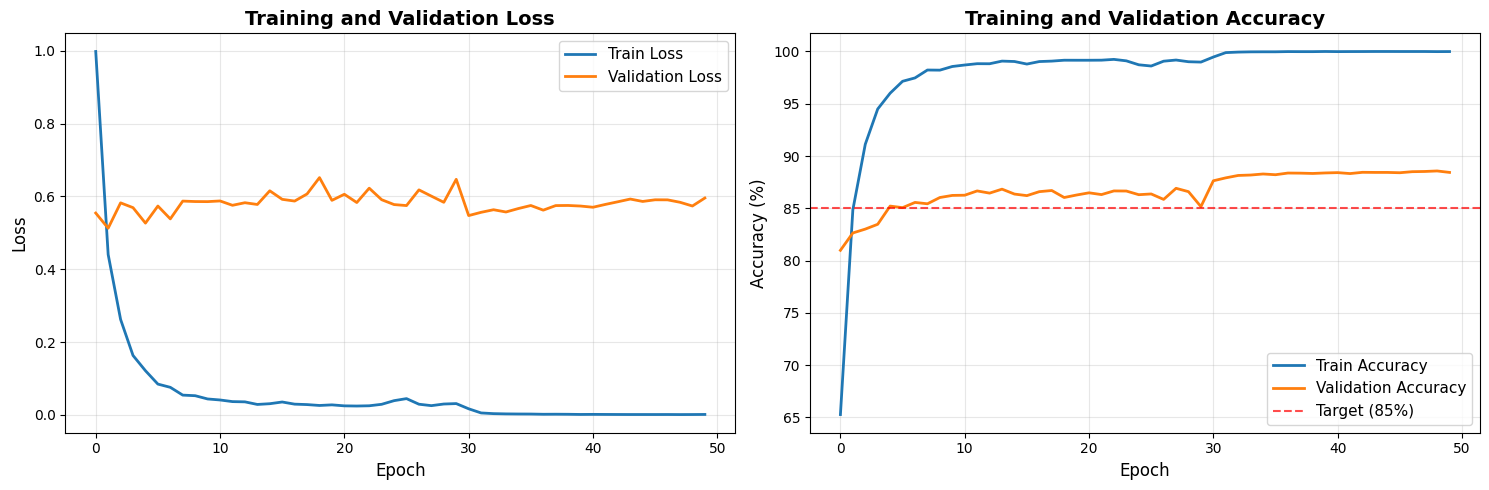

Training curves saved to results/level1_training_curves.png


In [ ]:
# Create results directory
os.makedirs('results', exist_ok=True)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, label='Validation Accuracy', linewidth=2)
ax2.axhline(y=85, color='r', linestyle='--', label='Target (85%)', alpha=0.7)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/level1_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Training curves saved to results/level1_training_curves.png')
